In [1]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
from math import ceil, floor, log10, log2

def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [44]:
methods = ["TrueCardinality", "SafeBound", "Postgres"]
benchmarks = ['JOBLight', "JOBLightRanges", "JOBM", "Stats"]
#benchmarks = ["Stats"]

runtimeResults = {method : dict() for method in methods}
rootFileDirectory = "/home/ec2-user/FrequencyBounds/Data/Results/"
for method in methods:
    for benchmark in benchmarks:
        try:
            querySize = pd.read_csv(rootFileDirectory + benchmark+"_Sizes.csv")
            resultFile = None
            if method == 'SafeBound':
                resultFile = rootFileDirectory + method + "_Runtime_" + str(4) + "_" + benchmark + ".csv"
            elif method == 'Postgres':
                resultFile = rootFileDirectory + method + "_Runtime_" + str(2) + "_" + benchmark + ".csv"
            elif method == 'TrueCardinality':
                resultFile = rootFileDirectory + method + "_Runtime_" + benchmark + ".csv" 

            resultData = pd.read_csv(resultFile)
            resultData = resultData.merge(querySize, on='QueryLabel')
            resultData["Benchmark"] = benchmark
            resultData["Method"] = method
            if "RunLabel" not in resultData.columns:
                resultData["RunLabel"] = 0
            runtimeResults[method][benchmark] = resultData
        except:
            print("No Data For " + method + " on " + benchmark)

In [45]:
OverallRuntimes = pd.concat([runtimeResults[method][benchmark] for method in methods for benchmark in benchmarks])
allRuntimes = pd.concat([runtimeResults[method][benchmark] for method in methods for benchmark in benchmarks])
allRuntimes = allRuntimes.groupby(["QueryLabel", "Benchmark", "Method", "StatsSize"]).mean().reset_index()

In [46]:
OverallRuntimes = OverallRuntimes.groupby(["Benchmark", "Method", "StatsSize", "RunLabel"]).sum().reset_index()
for benchmark in benchmarks:
    postgresRuntime = OverallRuntimes[(OverallRuntimes["Benchmark"]== benchmark)&(OverallRuntimes["Method"]=='TrueCardinality')]['Runtime'].mean()
    postgresInference = OverallRuntimes[(OverallRuntimes["Benchmark"]== benchmark)&(OverallRuntimes["Method"]=='Postgres')]['InferenceTime'].iloc[0]
    OverallRuntimes.loc[OverallRuntimes["Benchmark"]==benchmark, 'Runtime']  /=  postgresRuntime
    OverallRuntimes.loc[((OverallRuntimes["Benchmark"]==benchmark) & (~OverallRuntimes["Method"].isin(["Postgres", "Postgres2D"]))), 'InferenceTime'] += postgresInference 
OverallRuntimes["StatsSize"] /= 1000000

271.1286342
13599.5975728
125.05735380000002
1869.8237174


In [47]:
OverallRuntimes["NumQueries"] = 1
for benchmark in benchmarks:
    OverallRuntimes.loc[OverallRuntimes["Benchmark"] == benchmark, "NumQueries"] = len(runtimeResults["Postgres"][benchmark])
OverallRuntimes["InferenceTime"] = OverallRuntimes["InferenceTime"]/OverallRuntimes["NumQueries"]

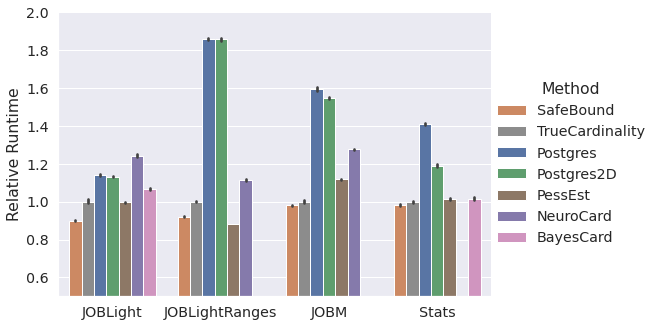

In [48]:
runtimePalette = ["C1", "C7", "C0"]
runtimeHueOrder = [ "SafeBound","TrueCardinality", "Postgres"]
sn.set(rc={'figure.figsize':(14,6)})
sn.set_style("whitegrid")
sn.set_color_codes("pastel")
sn.set(font_scale = 1.3)
runtimePlot = sn.catplot(y="Runtime", x="Benchmark", hue="Method", height=5, aspect=6/4, data= OverallRuntimes, palette=runtimePalette, hue_order=runtimeHueOrder, kind='bar')
runtimePlot.set(ylabel="Relative Runtime", xlabel='', ylim=(.5, 2))

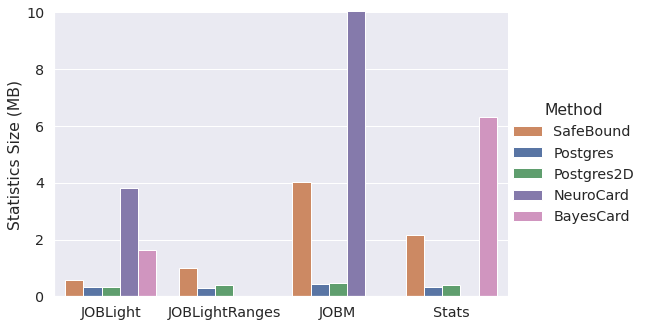

In [43]:
palette = ["C1", "C0", "C2", "C4", "C6"]
hueOrder = ["SafeBound", "Postgres"]
sizePlot = sn.catplot(y="StatsSize", x="Benchmark", hue="Method", data= OverallRuntimes, kind='bar', palette=palette, hue_order=hueOrder, height=5, aspect=6/4)
sizePlot.set(ylabel="Statistics Size (MB)", xlabel='', yscale="linear", ylim=[0,10])

/tmp/ipykernel_425018/2544009367.py:38: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


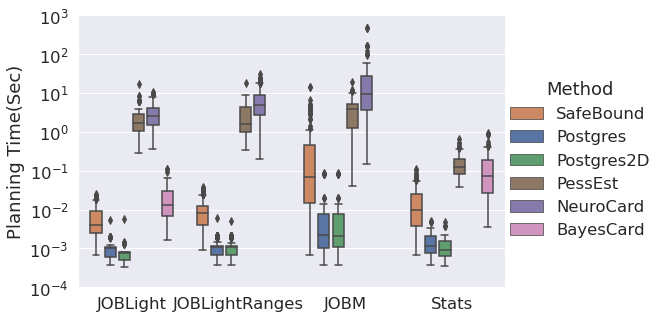

In [11]:
palette = ["C1", "C0"]
hueOrder = ["SafeBound", "Postgres"]
sizePlot = sn.catplot(y="InferenceTime", x="Benchmark", hue="Method", data= allRuntimes, palette=palette, hue_order=hueOrder, kind='box', height=5, aspect=6/4, width=.8, legend=True)
sizePlot.set(ylabel="Planning Time(Sec)", xlabel='', yscale='log', ylim=[.0001,1000])
adjust_box_widths(sizePlot.figure, 0.8)

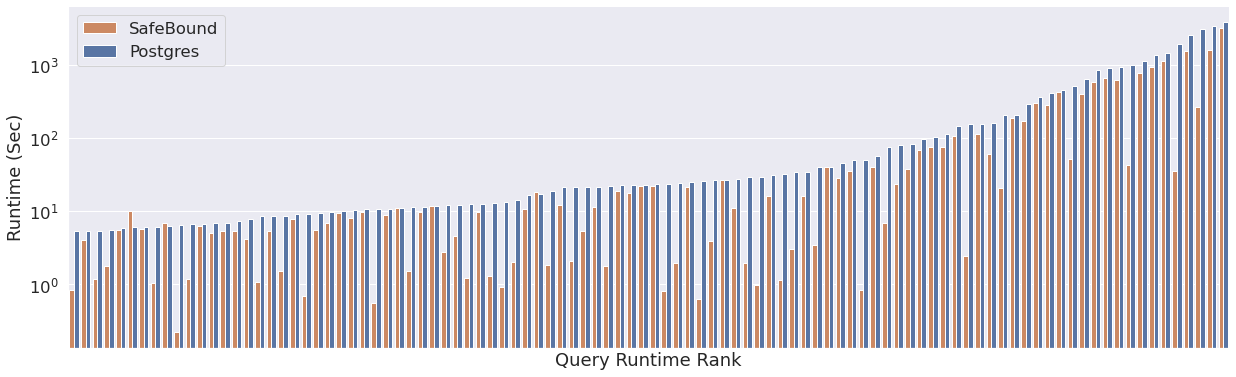

In [15]:
allRuntimes = pd.concat([runtimeResults[method][benchmark] for method in methods for benchmark in benchmarks])
allRuntimes = allRuntimes.groupby(["QueryLabel", "Benchmark", "Method", "StatsSize"]).mean().reset_index()
allRuntimes["QueryID"] = allRuntimes["Benchmark"] + allRuntimes["QueryLabel"].astype(str)
allRuntimes = allRuntimes.merge(allRuntimes[allRuntimes["Method"]=="Postgres"], on="QueryID", suffixes=('', '_Postgres'))
allRuntimes["RuntimeRank"] = allRuntimes.groupby(["Method"])["Runtime_Postgres"].rank(method="first")
largestRuntimes = allRuntimes.groupby(["Method"]).apply(lambda x: x.nlargest(100, 'Runtime_Postgres')).reset_index(drop=True)
largestRuntimes["RuntimeRank"] =  largestRuntimes["RuntimeRank"]  - min(largestRuntimes["RuntimeRank"])
largestRuntimes = largestRuntimes[largestRuntimes["Method"].isin(["Postgres", "SafeBound"])]
largestRuntimes.sort_values(["Method", "QueryLabel", "Benchmark"])
sn.set_style("whitegrid")
sn.set_color_codes("pastel")
sn.set(font_scale = 1.5)
plot = sn.catplot(y="Runtime", x="RuntimeRank", hue="Method", height=6, aspect=12/4, data=largestRuntimes, palette=["C1", "C0"], hue_order=["SafeBound", "Postgres"], kind='bar', legend=False)
plot.set(yscale='log', xticks=[], ylabel="Runtime (Sec)", xlabel="Query Runtime Rank")
plt.legend(loc="upper left")
#plot2 = sn.catplot(y="Runtime", x="JoinRank", hue="Method", height=7, aspect=12/4, data=smallestRuntimes, palette=["C1", "C3"], hue_order=["Postgres", "SafeBound"], kind='bar')
#plot2.set(yscale='log', xticks=[], ylabel="Runtime (Sec)")

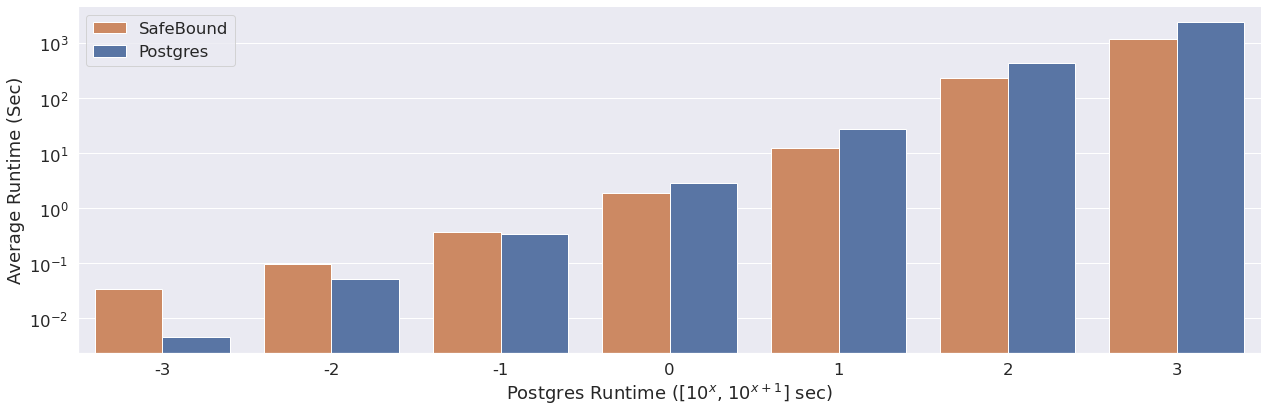

In [17]:
allRuntimes = pd.concat([runtimeResults[method][benchmark] for method in methods for benchmark in benchmarks])
allRuntimes = allRuntimes.groupby(["QueryLabel", "Benchmark", "Method", "StatsSize"]).mean().reset_index()
allRuntimes["QueryID"] = allRuntimes["Benchmark"] + allRuntimes["QueryLabel"].astype(str)
binnedRuntimes = allRuntimes.merge(allRuntimes[allRuntimes["Method"]=="Postgres"], on="QueryID", suffixes=('', '_Postgres'))
binnedRuntimes["RuntimeBin"] = binnedRuntimes["Runtime_Postgres"].apply(lambda x: floor(log10(x)))
binnedRuntimes = binnedRuntimes.groupby(['Method', 'RuntimeBin']).mean().reset_index()
sn.set(rc={'figure.figsize':(14,6)})
sn.set_style("whitegrid")
sn.set_color_codes("pastel")
sn.set(font_scale = 1.5)
plot = sn.catplot(y="Runtime", x="RuntimeBin", hue="Method", height=6, aspect=12/4, data=binnedRuntimes, palette=["C1", "C0"], hue_order=["SafeBound", "Postgres"], kind='bar', legend=False)
plot.set(yscale='log', ylabel="Average Runtime (Sec)", xlabel=r"Postgres Runtime ([$10^{x}$, $10^{x+1}$] sec)")
plt.legend()

In [18]:
allRuntimes = pd.concat([runtimeResults[method][benchmark] for method in methods for benchmark in benchmarks])
allRuntimes = allRuntimes.groupby(["QueryLabel", "Benchmark", "Method", "StatsSize"]).mean().reset_index()
allRuntimes["QueryID"] = allRuntimes["Benchmark"] + allRuntimes["QueryLabel"].astype(str)
allRuntimes = allRuntimes.merge(allRuntimes[allRuntimes["Method"]=="Postgres"], on="QueryID", suffixes=('', '_Postgres'))
largestRuntimes = allRuntimes.groupby(["Method"]).apply(lambda x: x.nlargest(80, 'Runtime_Postgres')).reset_index(drop=True)
largestRuntimes = largestRuntimes[largestRuntimes["Method"].isin(["SafeBound"])]
largestRuntimes["SafeBoundSpeedup"] = largestRuntimes["Runtime_Postgres"]/largestRuntimes["Runtime"]
largestRuntimes["SafeBoundSpeedup"].quantile(.05)

1.0080648006854873

In [5]:
methods = ["TrueCardinality", "SafeBound", "Postgres"]
benchmarks = ['JOBLight', "JOBLightRanges", "JOBM", "Stats"]
#benchmarks = ["Stats"]

runtimeResults = {method : dict() for method in methods}
rootFileDirectory = "/home/ec2-user/FrequencyBounds/Data/Results/"
for method in methods:
    for benchmark in benchmarks:
        try:
            querySize = pd.read_csv(rootFileDirectory + benchmark+ "_Sizes.csv")
            resultFile = None
            if method == 'SafeBound':
                resultFile = rootFileDirectory + method + "_Runtime_" + str(4) + "_" + benchmark + "_NP.csv"
            elif method == 'Postgres':
                resultFile = rootFileDirectory + method + "_Runtime_" + str(2) + "_" + benchmark + "_NP.csv"
            elif method == 'TrueCardinality':
                resultFile = rootFileDirectory + method + "_Runtime_" + benchmark + "_NP.csv" 
            
            resultData = pd.read_csv(resultFile)
            resultData = resultData.merge(querySize, on='QueryLabel')
            resultData["Benchmark"] = benchmark
            resultData["Method"] = method
            if "RunLabel" not in resultData.columns:
                resultData["RunLabel"] = 0
            runtimeResults[method][benchmark] = resultData
        except:
            print("No Data For " + method + " on " + benchmark)

In [6]:
allRuntimes = pd.concat([runtimeResults[method][benchmark] for method in methods for benchmark in benchmarks])
OverallRuntimes = pd.concat([runtimeResults[method][benchmark] for method in methods for benchmark in benchmarks])

In [9]:
OverallRuntimes = OverallRuntimes.groupby(["Benchmark", "Method", "StatsSize", "RunLabel"]).sum().reset_index()
for benchmark in benchmarks:
    postgresRuntime = OverallRuntimes[(OverallRuntimes["Benchmark"]== benchmark)&(OverallRuntimes["Method"]=='TrueCardinality')]['Runtime'].mean()
    postgresInference = OverallRuntimes[(OverallRuntimes["Benchmark"]== benchmark)&(OverallRuntimes["Method"]=='Postgres')]['InferenceTime'].iloc[0]
    OverallRuntimes.loc[OverallRuntimes["Benchmark"]==benchmark, 'Runtime']  /=  postgresRuntime
    OverallRuntimes.loc[((OverallRuntimes["Benchmark"]==benchmark) & (~OverallRuntimes["Method"].isin(["Postgres", "Postgres2D"]))), 'InferenceTime'] += postgresInference 
OverallRuntimes["StatsSize"] /= 1000000

In [10]:
OverallRuntimes["NumQueries"] = 1
for benchmark in benchmarks:
    OverallRuntimes.loc[OverallRuntimes["Benchmark"] == benchmark, "NumQueries"] = len(runtimeResults["Postgres"][benchmark])
OverallRuntimes["InferenceTime"] = OverallRuntimes["InferenceTime"]/OverallRuntimes["NumQueries"]

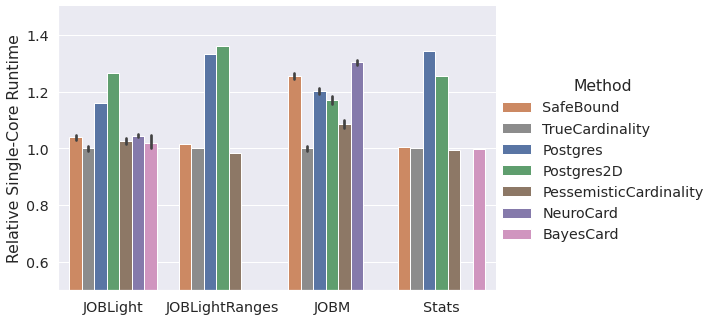

In [11]:
runtimePalette = ["C1", "C7", "C0"]
runtimeHueOrder = [ "SafeBound","TrueCardinality", "Postgres"]
sn.set(rc={'figure.figsize':(14,6)})
sn.set_style("whitegrid")
sn.set_color_codes("pastel")
sn.set(font_scale = 1.3)
runtimePlot = sn.catplot(y="Runtime", x="Benchmark", hue="Method", height=5, aspect=6/4, data= OverallRuntimes, palette=runtimePalette, hue_order=runtimeHueOrder, kind='bar')
runtimePlot.set(ylabel="Relative Single-Core Runtime", xlabel='', ylim=(.5, 1.5))

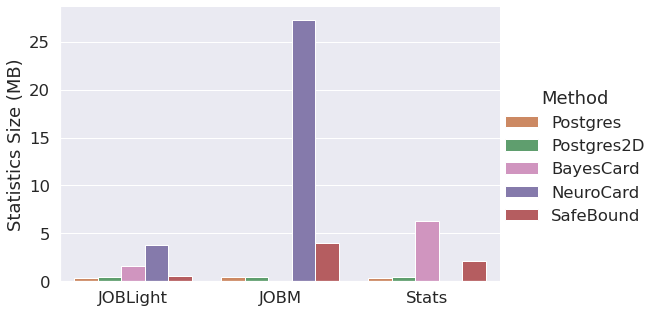

In [497]:
sizePlot = sn.catplot(y="StatsSize", x="Benchmark", hue="Method", data= OverallRuntimes, kind='bar', palette=["C1", "C2", "C6", "C4", "C3"], hue_order=["Postgres", "Postgres2D","BayesCard", "NeuroCard", "SafeBound"], height=5, aspect=6/4)
sizePlot.set(ylabel="Statistics Size (MB)", xlabel='')

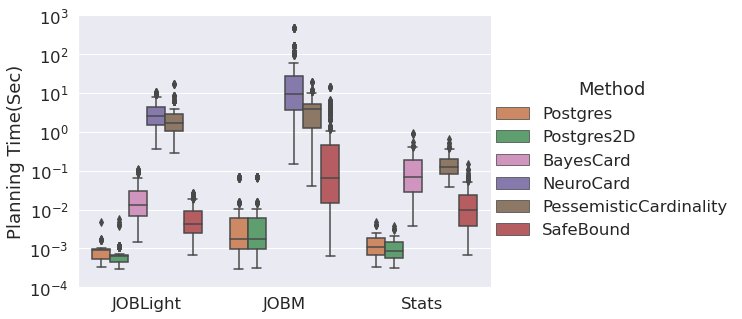

In [498]:
sizePlot = sn.catplot(y="InferenceTime", x="Benchmark", hue="Method", data= allRuntimes, palette=["C1", "C2", "C6", "C4", "C5", "C3"], hue_order=["Postgres", "Postgres2D","BayesCard", "NeuroCard", "PessemisticCardinality", "SafeBound"], kind='box', height=5, aspect=6/4)
sizePlot.set(ylabel="Planning Time(Sec)", xlabel='', yscale='log', ylim=[.0001,1000])

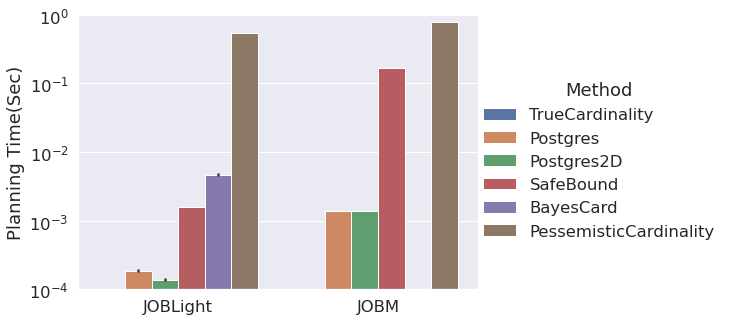

In [258]:
sizePlot = sn.catplot(y="InferenceTime", x="Benchmark", hue="Method", data= OverallRuntimes,hue_order=["TrueCardinality", "Postgres", "Postgres2D", "SafeBound","BayesCard", "PessemisticCardinality"], kind='bar', height=5, aspect=6/4)
sizePlot.set(ylabel="Planning Time(Sec)", xlabel='', yscale='log', ylim=[.0001,1])

In [48]:
methods = ["SafeBound", "Postgres"]
#methods = ["TrueCardinality", "SafeBound", "Postgres", "Postgres2D"]
benchmarks = ["Stats", "StatsPK"]
runtimeResults = {method : dict() for method in methods}
rootFileDirectory = "/home/ec2-user/FrequencyBounds/Data/Results/"
for method in methods:
    for benchmark in benchmarks:
        try:
            
            querySize = pd.read_csv(rootFileDirectory + "Stats"+"_Sizes.csv")
            resultFile = None
            if method == 'SafeBound':
                resultFile = rootFileDirectory + method + "_Runtime_" + str(4) + "_" + benchmark + "_NP.csv"
                if benchmark in []:
                    resultData = pd.DataFrame()
                    runtimeResults[method][benchmark] = resultData
                    continue
            elif method == 'SafeBoundScan':
                resultFile = rootFileDirectory + method + "_Runtime_" + str(4) + "_" + benchmark + "_NP.csv"
                if benchmark in ["JOBLightRanges"]:
                    resultData = pd.DataFrame()
                    runtimeResults[method][benchmark] = resultData
                    continue
            elif method == 'Postgres' or method == "Postgres2D":
                resultFile = rootFileDirectory + method + "_Runtime_" + str(2) + "_" + benchmark + "_NP.csv"
                if benchmark in [""]:
                    resultData = pd.DataFrame()
                    runtimeResults[method][benchmark] = resultData
                    continue
            elif method == 'BayesCard':
                resultFile = rootFileDirectory + method + "_Runtime_" + benchmark + "_NP.csv"
                if benchmark in ["JOBLightRanges", "JOBM"]:
                    resultData = pd.DataFrame()
                    runtimeResults[method][benchmark] = resultData
                    continue
            elif method == 'TrueCardinality':
                resultFile = rootFileDirectory + method + "_Runtime_" + benchmark + "_NP.csv" 
                if benchmark in [""]:
                    resultData = pd.DataFrame()
                    runtimeResults[method][benchmark] = resultData
                    continue
            elif method == 'PessEst':
                resultFile = rootFileDirectory + "PessemisticCardinality" + "_Runtime_" + benchmark + "_NP.csv"
                if benchmark in []:
                    resultData = pd.DataFrame()
                    runtimeResults[method][benchmark] = resultData
                    continue
            elif method == 'NeuroCard':
                resultFile = rootFileDirectory + method + "_Runtime_" + benchmark + "_NP.csv"
                if benchmark in ["Stats"]:
                    resultData = pd.DataFrame()
                    runtimeResults[method][benchmark] = resultData
                    continue
            
            resultData = pd.read_csv(resultFile)
            resultData = resultData.merge(querySize, on='QueryLabel')
            resultData["Benchmark"] = benchmark
            resultData["Method"] = method
            resultData = resultData.groupby(["QueryLabel", "Benchmark", "Method"]).mean().reset_index()
            if "RunLabel" not in resultData.columns:
                resultData["RunLabel"] = 0
            runtimeResults[method][benchmark] = resultData
        except:
            print("No Data For " + method + " on " + benchmark)

In [71]:
safeBoundResults = runtimeResults["SafeBound"]["Stats"].merge(runtimeResults["SafeBound"]["StatsPK"], on="QueryLabel", suffixes=["","_PK"])
safeBoundResults = safeBoundResults[safeBoundResults["Runtime"] >= safeBoundResults["Runtime"].quantile(.25)]
postgresResults = runtimeResults["Postgres"]["Stats"].merge(runtimeResults["Postgres"]["StatsPK"], on="QueryLabel", suffixes=["","_PK"])
postgresResults = postgresResults[postgresResults["Runtime"] >= postgresResults["Runtime"].quantile(.25)]

In [72]:
safeBoundResults["RelativeRuntime"] = safeBoundResults["Runtime_PK"]/safeBoundResults["Runtime"]
postgresResults["RelativeRuntime"] = postgresResults["Runtime_PK"] /postgresResults["Runtime"]
allResults = pd.concat([safeBoundResults, postgresResults])

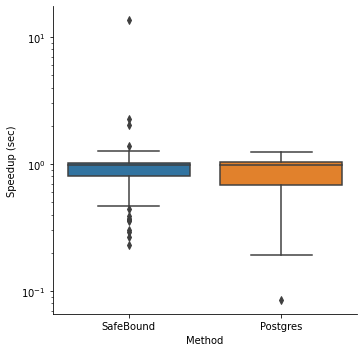

In [73]:
plot = sn.catplot(data=allResults, y="RelativeRuntime", x="Method", kind="box")
plot.set(ylabel='Speedup (sec)', yscale='log')